# **Task 3: Heart Disease Prediction**

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Import and load Heart Disease UCI dataset from Kagglehub
import kagglehub
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")
df = pd.read_csv(f'{path}/heart_disease_uci.csv')

Using Colab cache for faster access to the 'heart-disease-data' dataset.


In [3]:
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [4]:
df.shape

(920, 16)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [6]:
df.isnull().sum()

,0
id,0
age,0
sex,0
dataset,0
cp,0
trestbps,59
chol,30
fbs,90
restecg,2
thalch,55


## **Data Cleaning:**

In [7]:
# drop unnecessary column
df.drop(['id', 'dataset'], axis=1, inplace=True)

In [8]:
# Impute categorical/ordinal features with the mode
for col in ['slope', 'thal', 'restecg']:
    df[col] = df[col].fillna(df[col].mode()[0])

In [9]:
# Imputing features containing Boolean values with mode + missing indicator
for col in ['fbs', 'exang']:
    df[col + '_was_missing'] = df[col].isna()
    df[col] = df[col].fillna(df[col].mode()[0])

/tmp/ipython-input-2301654245.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])
/tmp/ipython-input-2301654245.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])


In [10]:
# Adding missing indicator for ca column 'cause of very high missingness percentage
df['ca' + '_was_missing'] = df['ca'].isna()

In [11]:
# Impute numerical columns with median
for col in ['trestbps', 'chol', 'thalch', 'oldpeak', 'ca']:
  df[col] = df[col].fillna(df[col].median())

In [12]:
df.isnull().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalch,0
exang,0
oldpeak,0


In [13]:
# Target value in binary
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

## **EDA:**

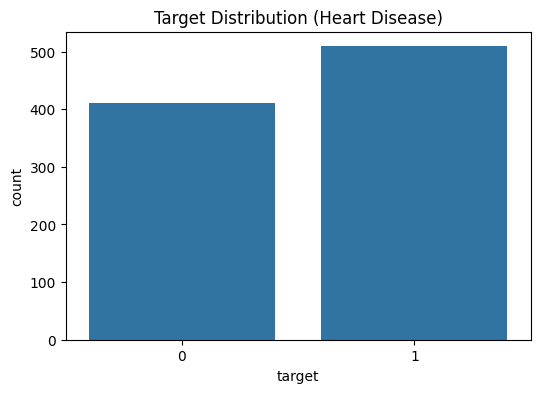

In [14]:
# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='target')
plt.title("Target Distribution (Heart Disease)")
plt.show()

The dataset usually has more patients with heart disease than without.

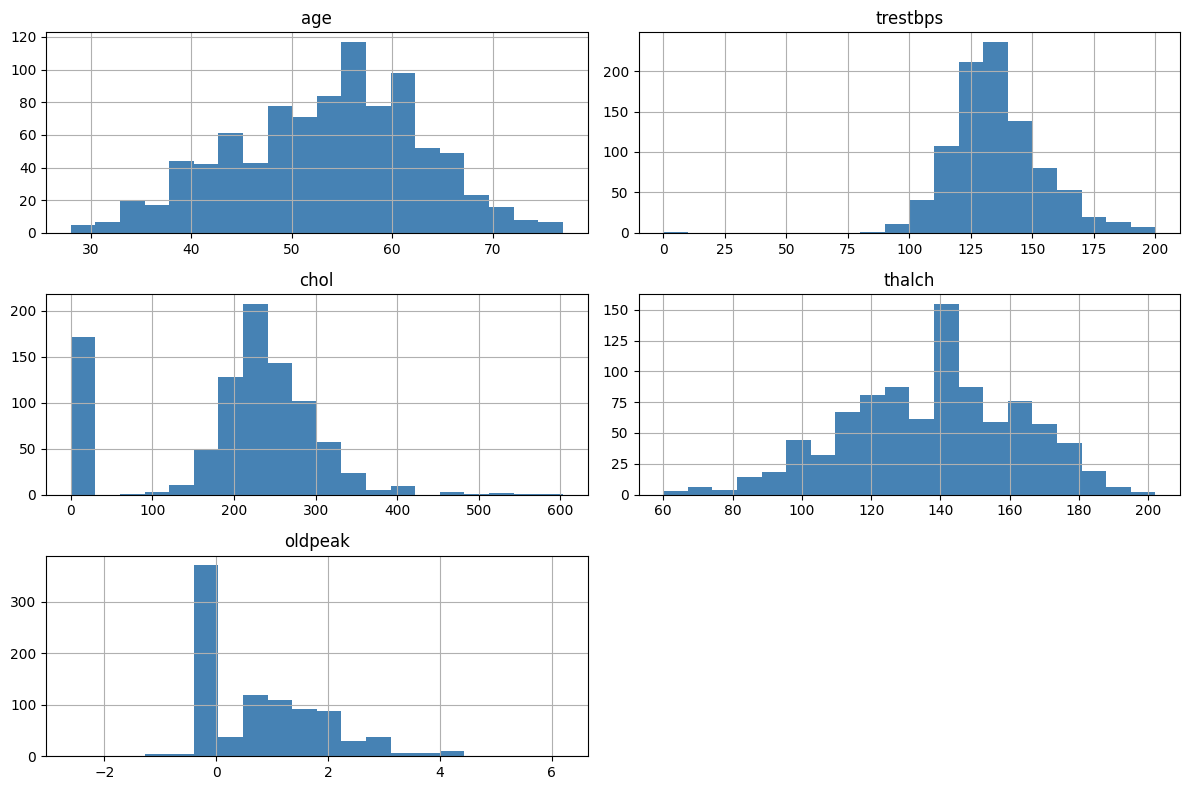

In [15]:
# hist plot for numerical features
num_cols = ['age','trestbps','chol','thalch','oldpeak']

df[num_cols].hist(figsize=(12,8), bins=20, color="steelblue")
plt.tight_layout()
plt.show()

Age: usually centered around 55

trestbps (resting BP): slightly right-skewed

chol: often heavy-tailed (high cholesterol common)

thalch: higher HR tends to be healthier

oldpeak: (skewed) most patients have small ST depressions

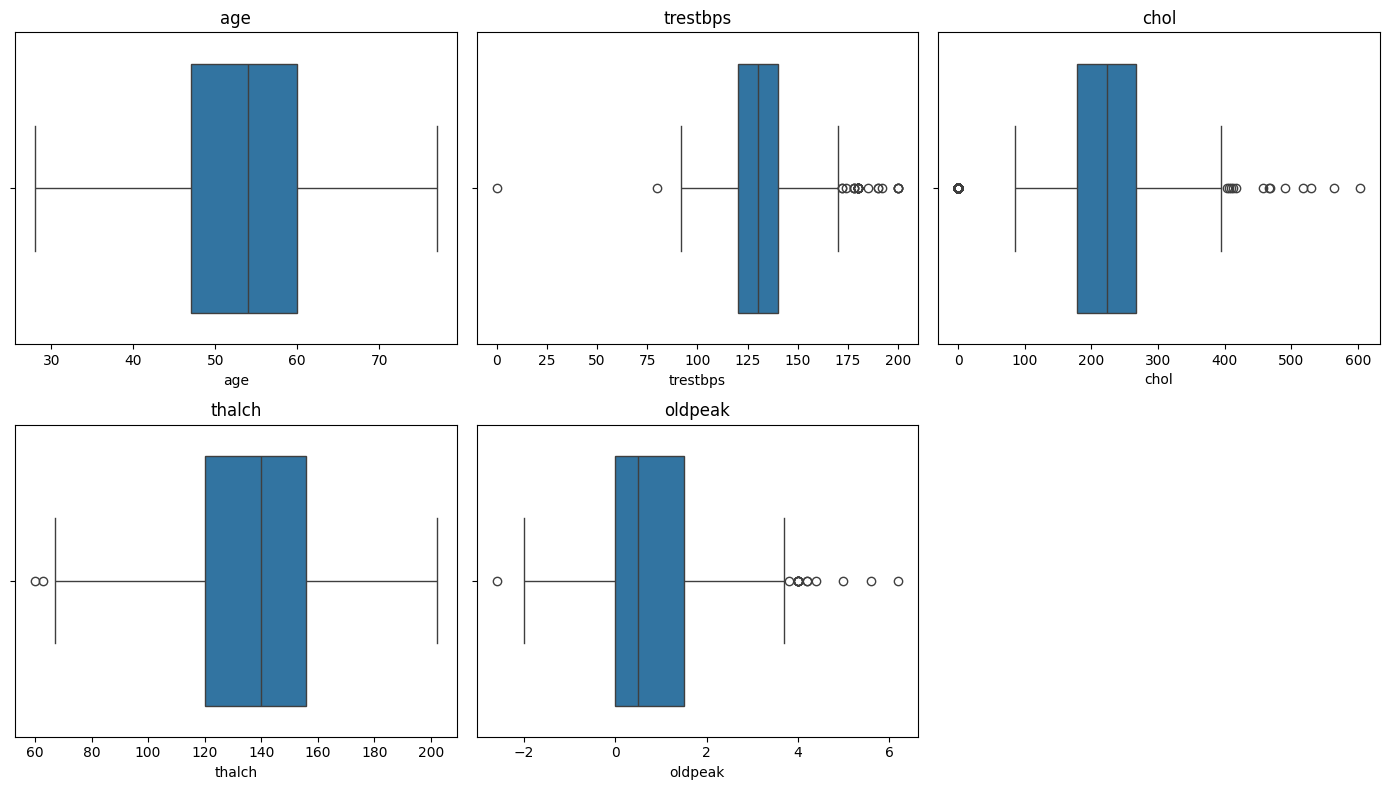

In [16]:
# Box plot for outliers
plt.figure(figsize=(14, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

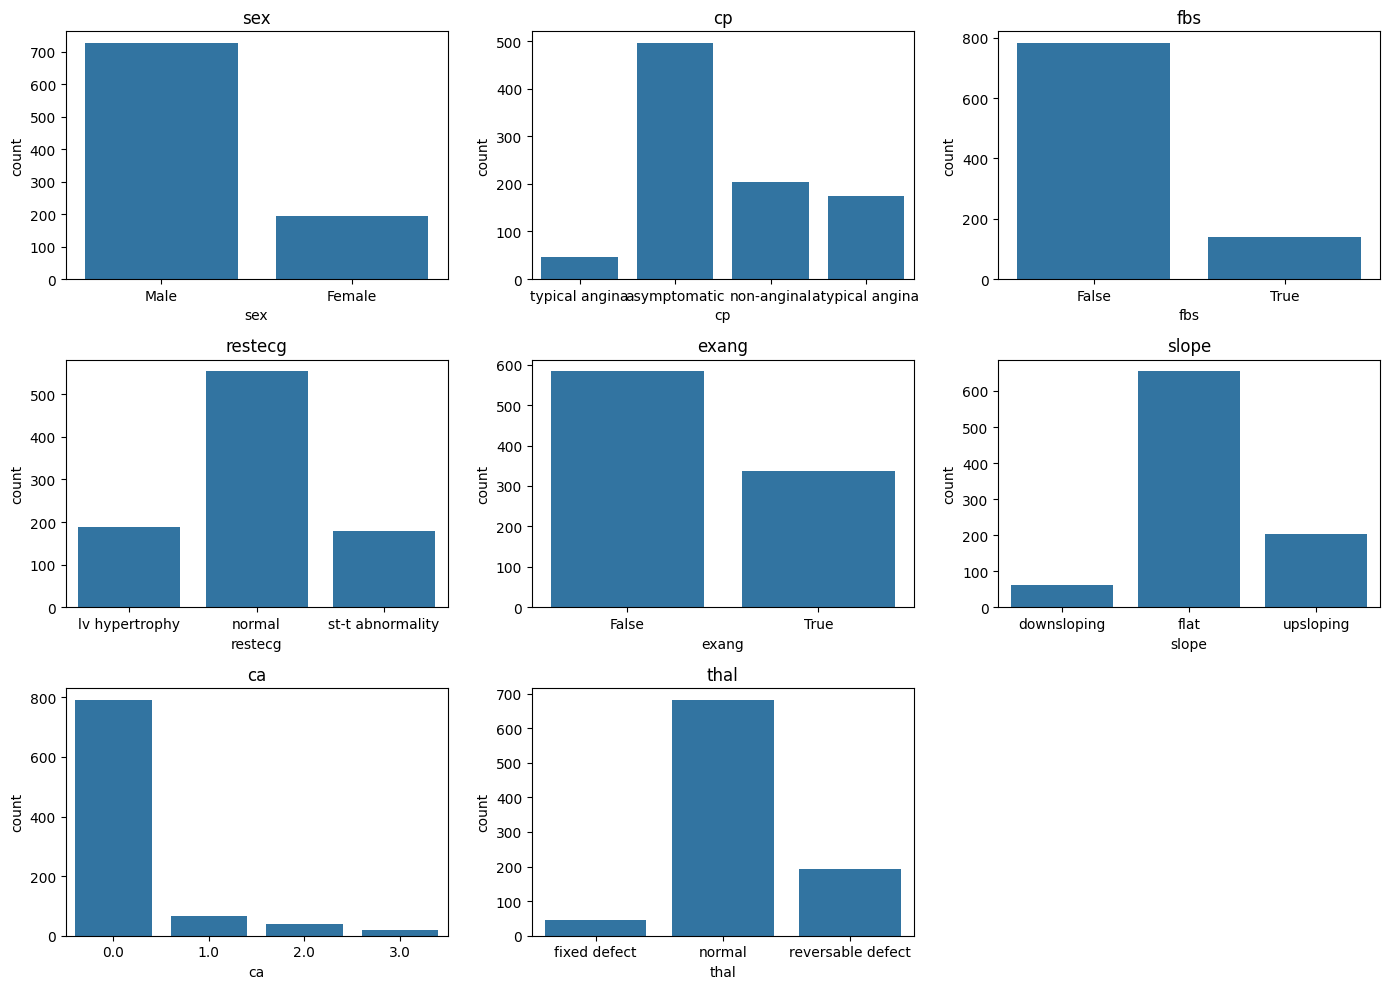

In [17]:
# Count catagorical data
cat_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']

plt.figure(figsize=(14,10))
for i, col in enumerate(cat_cols):
    plt.subplot(3, 3, i+1)
    sns.countplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.tick_params()
plt.show()

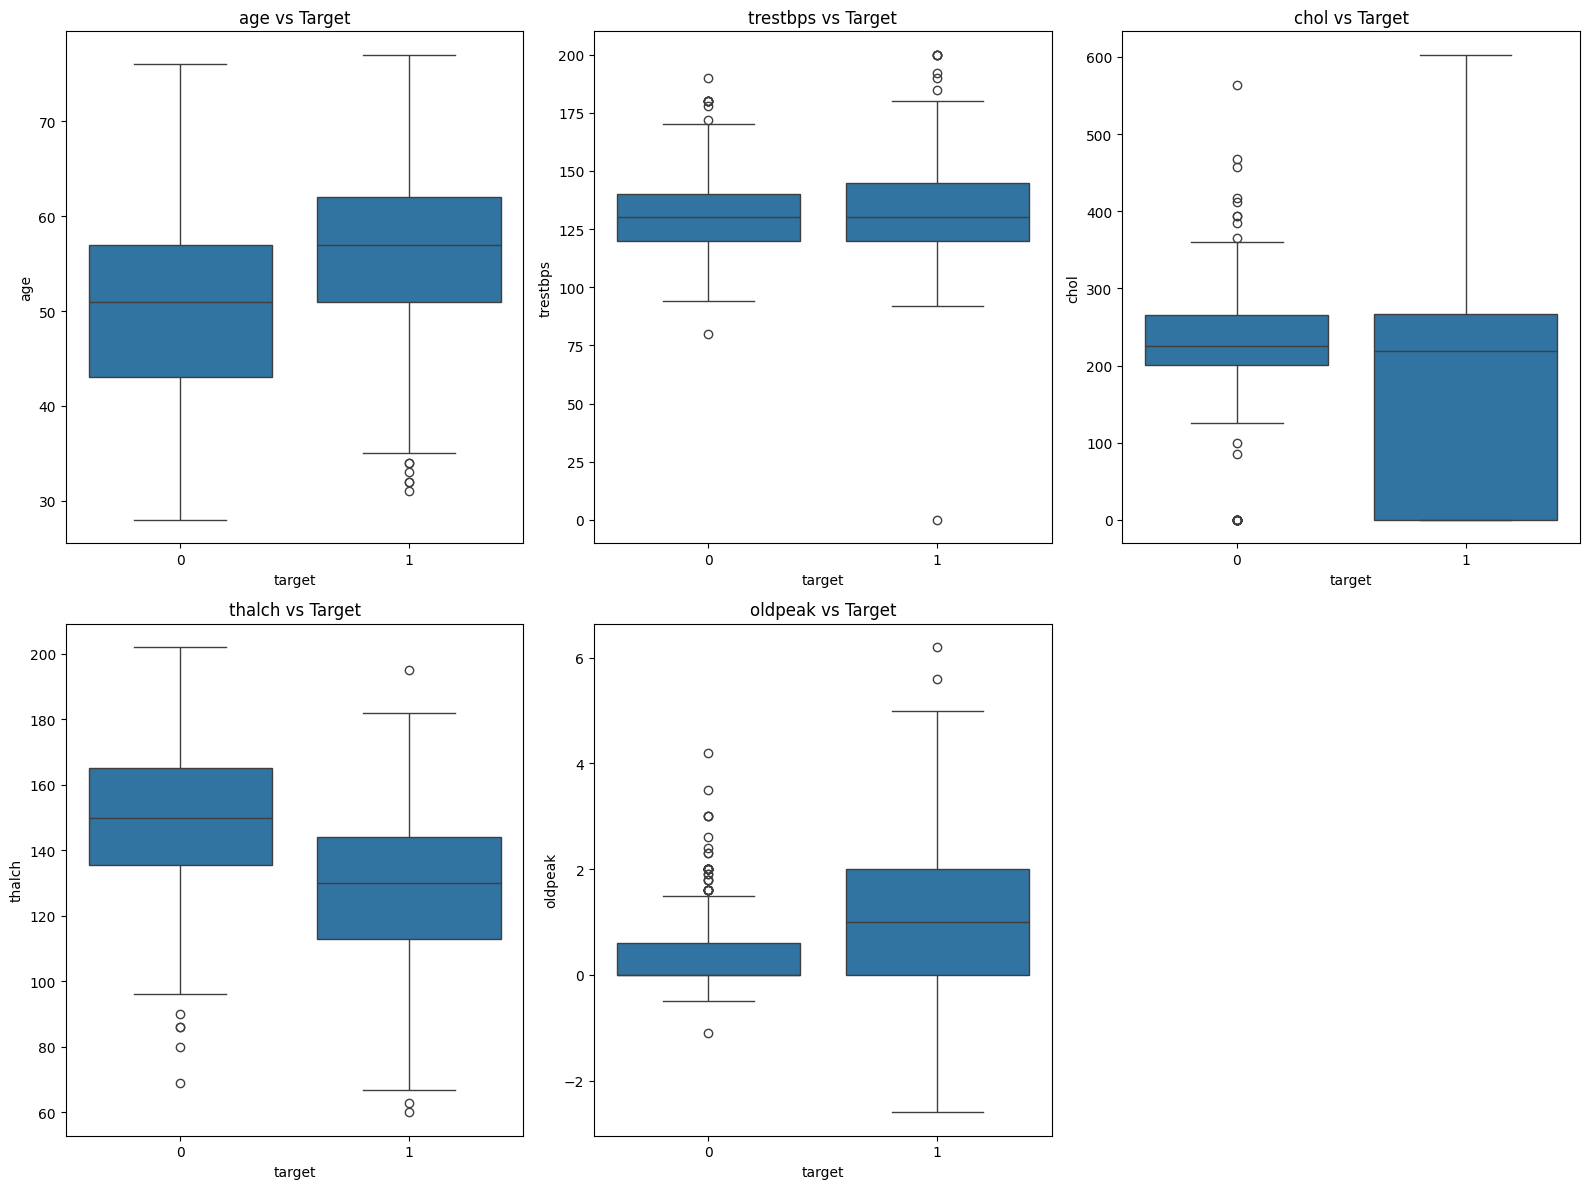

In [18]:
# numeriacal vs target

plt.figure(figsize=(16, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, x='target', y=col)
    plt.title(f"{col} vs Target")
plt.tight_layout()
plt.show()

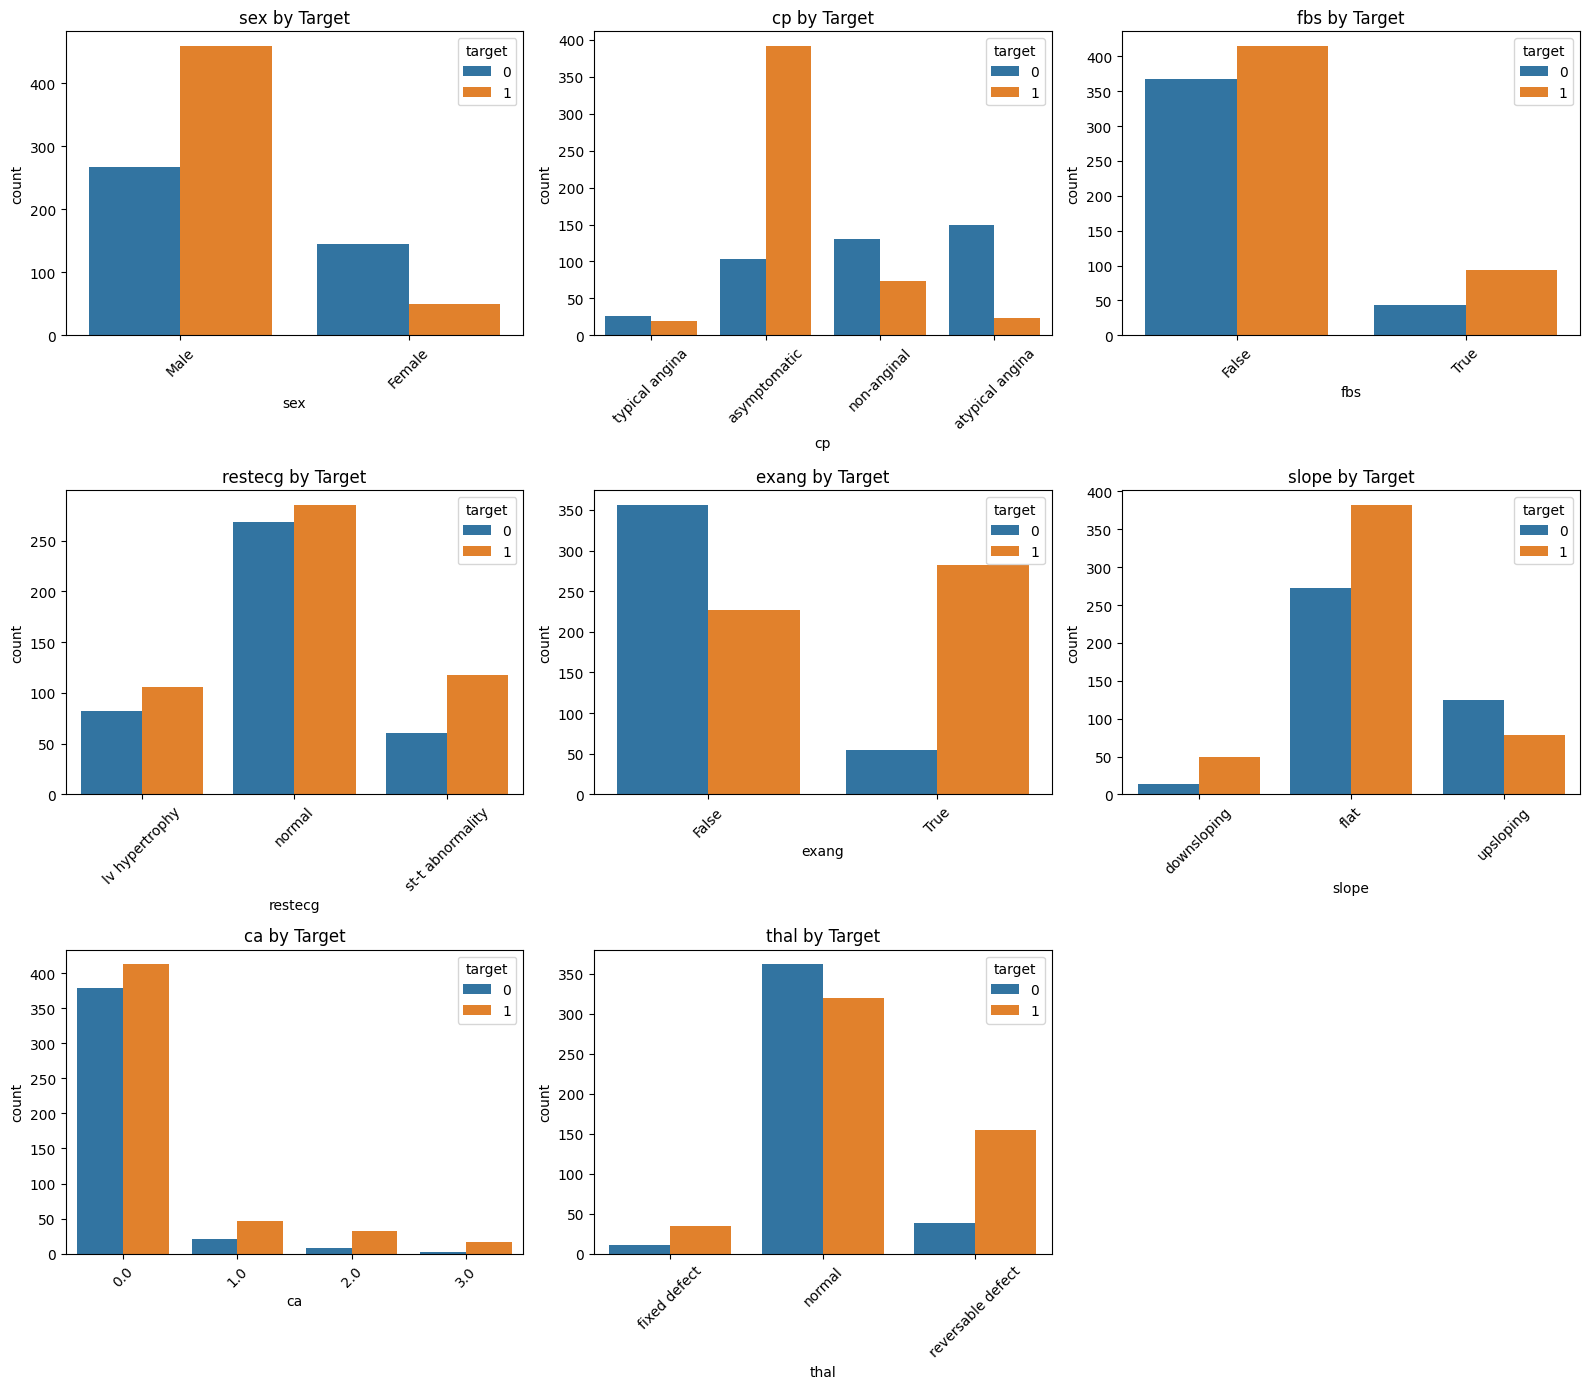

In [19]:
# catagorical vs target

plt.figure(figsize=(16, 14))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=df, x=col, hue='target')
    plt.xticks(rotation=45)
    plt.title(f"{col} by Target")
plt.tight_layout()
plt.show()

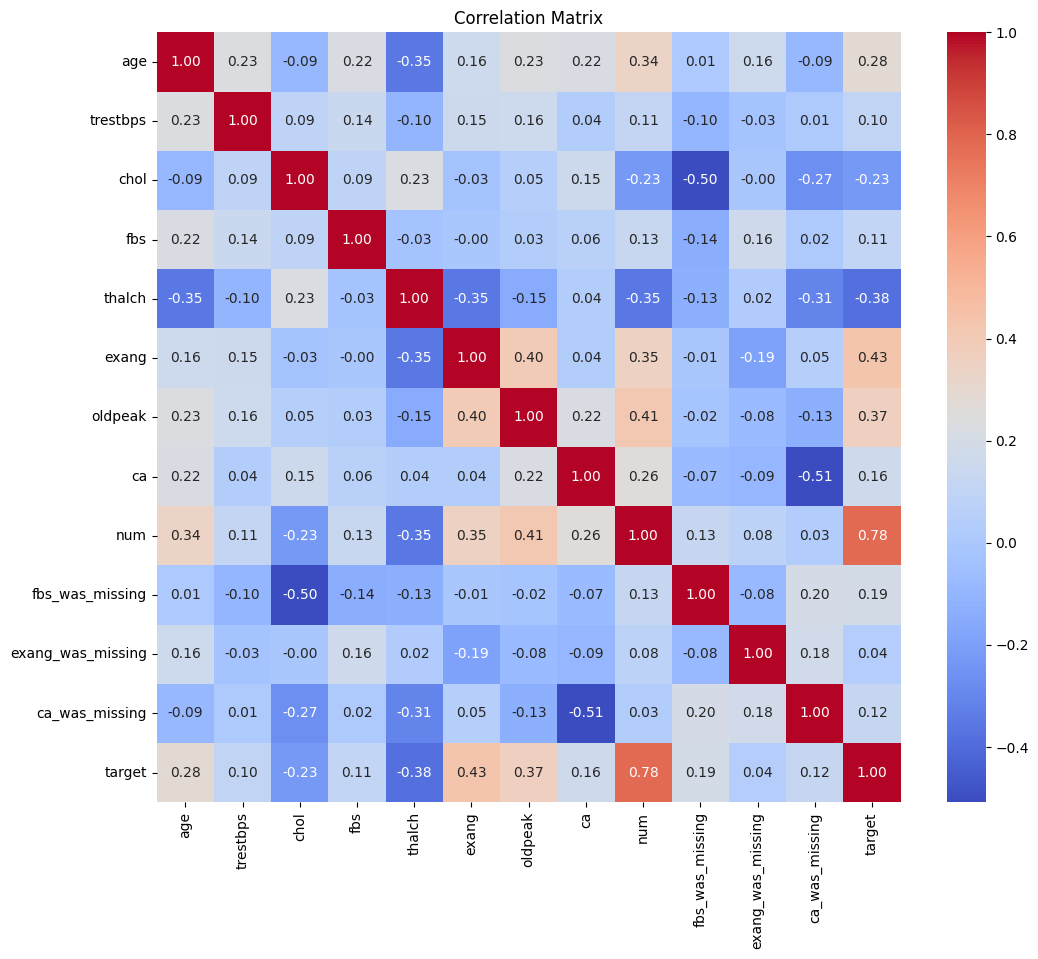

In [20]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## **Model Training**

In [21]:
X = df.drop(columns=['target'])
y = df['target']

In [22]:
# Identify numerical & categorical
categorical_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [23]:
# Encoding Categorical Features

encoder = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ],
    remainder="passthrough"
)

X_encoded = encoder.fit_transform(X)

In [24]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

In [25]:
# Train Logistic Regression
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500)

In [26]:
# Predictions & Accuracy

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 1.0


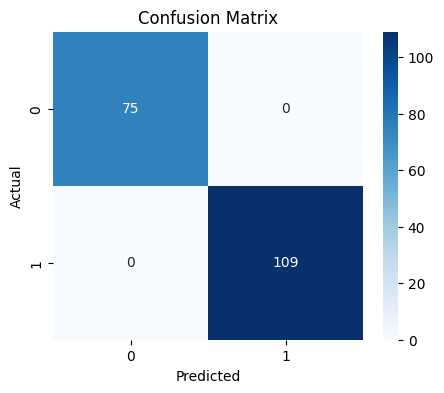

In [27]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [28]:
cm

array([[ 75,   0],
       [  0, 109]])